# IMPORTS

In [165]:
import yaml
import firebase_admin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from scipy import stats
import seaborn as sns

import requests
import json

from math import sin, cos, sqrt, atan2, radians


from firebase_admin import credentials
from firebase_admin import firestore

from matplotlib import pyplot

from matplotlib.patches import Polygon
from pandas.plotting import scatter_matrix

# CONNECT TO FIREBASE

In [2]:
filename='/Users/5danalfaro/OAN/credentials/firebase_parameters.json'

In [3]:
# Use a service account
cred = credentials.Certificate(filename)
firebase_admin.initialize_app(cred)

db = firestore.client()

# GET VILLAGE AND PRIORITY SURVEYS

In [63]:
col_query = db.collection('Surveys').document('Backup').collection('Answers').where(u'survey_type', u'==', u'2-survey_priority')


In [64]:
col_sur_priority = col_query.stream()

In [65]:
l_sur_priority = []
for doc in col_sur_priority:
    l_sur_priority.append(doc.to_dict())

In [66]:
len(set([a['coords']['longitude']for a in l_sur_priority]))

117

In [98]:
col_query = (db.collection('Surveys').
                    document('Backup').
                        collection('Answers').
                            where(u'survey_type', u'==', u'1-survey_village')
            )

In [99]:
col_sur_village = col_query.stream()

In [100]:
l_sur_village = []
for doc in col_sur_village:
    l_sur_village.append(doc.to_dict())

In [101]:
len(set([a['data']['village_coords'] for a in l_sur_village]))

10

In [102]:
len(l_sur_village)

10

In [103]:
[vil['data']['village_name'] for vil in l_sur_village]

['Bio Sika Kparou ',
 'Kora seko Kparou où Sansi Gah Gourou',
 'Sonkorou',
 'Debbo',
 'Danon',
 'Gbérou kpanin',
 'Wodora',
 'Alafiarou',
 'Tata Lafiarou ou Djonwouro Kparou ',
 'Chein Gbérou Kpanin']

In [104]:
[vil['data']['village_pop'] for vil in l_sur_village]

['200', 'null', '250', '120', '500', '150', '70', '400', '80', '300']

# PROCESS DATA

## PRIORISATION DATA

In [183]:
df_priority=pd.DataFrame([{'latitude':doc['coords']['latitude'],
  'longitude':doc['coords']['longitude'],
  'creation_date':doc['creation_date'],
  'nb_basin':doc['data']['nb_basin'],
  'nb_people':doc['data']['nb_people'],
  'nb_diarrhoea':doc['data']['nb_diarrhoea'],
  'nb_malnu':doc['data']['nb_malnu'],
  'water_storage':doc['data']['water_storage'],
  'water_quality':doc['data']['water_quality'],
  'self_manag':doc['data']['self_manag'],
  'role':doc['data']['role']
  
    } for doc in l_sur_priority
])

## Village data

In [106]:
df_village=pd.DataFrame(
    [{#'latitude':doc['coords']['latitude'],
      #'longitude':doc['coords']['longitude'],
      'village_coords':doc['data']['village_coords'],
      'creation_date':doc['creation_date'],
      'nb_water_sources':doc['data']['nb_water_sources'],
      'heath_center':doc['data']['heath_center'],
      'village_pop':doc['data']['village_pop'],
      'village_name':doc['data']['village_name'],
      'water_sources':doc['data']['water_sources']

        } for doc in l_sur_village
    ]
)

In [107]:
df_village['longitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[1],axis=1)

In [108]:
df_village['latitude']=df_village.apply(lambda x: x['village_coords'].split(' ;')[0],axis=1)

In [109]:
l_s_potable= ['PPM','AEV','FPM']

In [110]:
df_village['%_s_potable']=df_village.apply(
    lambda x: 100*(len([source['ws_type'] 
                   for source in x['water_sources'] if source['ws_type'] in l_s_potable])
                /float(x['nb_water_sources']))
    ,axis=1
)

### merge village and priority

In [184]:
'''get village from minimum distance to survey (and date of creation date)'''
def get_village(x):
    min_dist=1
    village=''
    prior_cre_date=x['creation_date']
    lat=float(x['latitude'])
    lon=float(x['longitude'])
    for vil_coords,vil_name in zip(df_village['village_coords'].to_list(),
                                   df_village['village_name'].to_list()
                                  ):
        vil_lat = float(vil_coords.split(' ;')[0])
        vil_lon = float(vil_coords.split(' ;')[1])
        
        distance=((vil_lat-lat)**2+(vil_lon-lon)**2)**0.5
        if min_dist > distance:
            min_dist=distance
            village=vil_name
    #print(prior_cre_date[5:10],
    #      df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     prior_cre_date[5:10]==df_village[df_village['village_name']==vil_name]['creation_date'].values[0][5:10],
    #     village)
    #        
    return village
        

In [185]:
df_priority['nb_people'] = pd.to_numeric(df_priority['nb_people'],errors='coerce')
df_priority['nb_diarrhoea'] = pd.to_numeric(df_priority['nb_diarrhoea'],errors='coerce')
df_priority['nb_malnu'] = pd.to_numeric(df_priority['nb_malnu'],errors='coerce')
df_priority['nb_basin'] = pd.to_numeric(df_priority['nb_basin'],errors='coerce')
df_priority['water_quality'] = pd.to_numeric(df_priority['water_quality'],errors='coerce')
df_priority['self_manag'] = pd.to_numeric(df_priority['self_manag'],errors='coerce')
df_priority['latitude'] = pd.to_numeric(df_priority['latitude'],errors='coerce')
df_priority['longitude'] = pd.to_numeric(df_priority['longitude'],errors='coerce')

In [186]:
df_priority['l/per']=df_priority['nb_basin']*25/df_priority['nb_people']

In [187]:
df_priority['t_diar']=df_priority['nb_diarrhoea']*100/df_priority['nb_people']

In [188]:
df_priority['t_mal']=df_priority['nb_malnu']*100/df_priority['nb_people']

In [189]:
df_priority['village']=df_priority.apply(lambda x: get_village(x),axis=1)

In [190]:
df_priority

,latitude,longitude,creation_date,nb_basin,nb_people,nb_diarrhoea,nb_malnu,water_storage,water_quality,self_manag,role,l/per,t_diar,t_mal,village
0,9.913798,3.404567,2019-11-01T08:11:00.456Z,7,4,1,1,NO,4.0,4,FIRST WOMAN,43.750000,25.000000,25.000000,Alafiarou
1,9.834493,3.340545,2019-11-04T09:27:28.400Z,15,25,0,0,NO,2.0,4,HEAD OF HOUSEHOLD [MALE],15.000000,0.000000,0.000000,Sonkorou
2,9.773152,3.099897,2019-11-06T13:54:52.987Z,20,29,5,0,NO,2.0,5,HEAD OF HOUSEHOLD [MALE],17.241379,17.241379,0.000000,Danon
3,9.900368,3.404947,2019-10-30T15:56:30.815Z,8,17,3,0,NO,1.0,4,FIRST WOMAN,11.764706,17.647059,0.000000,Alafiarou
4,9.914502,3.404680,2019-11-01T08:18:44.907Z,9,14,3,0,NO,2.0,4,ANOTHER WOMAN,16.071429,21.428571,0.000000,Alafiarou
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,9.862973,3.283767,2019-11-02T12:40:57.354Z,19,15,4,0,NO,2.0,4,FIRST WOMAN,31.666667,26.666667,0.000000,Debbo
113,9.772353,3.100568,2019-11-06T13:36:34.305Z,22,27,10,3,NO,1.0,3,FIRST WOMAN,20.370370,37.037037,11.111111,Danon
114,9.886402,3.261683,2019-11-02T10:43:10.355Z,14,12,3,0,NO,2.0,4,HEAD OF HOUSEHOLD [MALE],29.166667,25.000000,0.000000,Debbo
115,9.878485,3.270460,2019-11-02T11:21:20.038Z,20,10,1,0,NO,2.0,4,HEAD OF HOUSEHOLD [MALE],50.000000,10.000000,0.000000,Debbo


In [118]:
df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'l/per':'mean',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    't_diar':'mean',
                                    't_mal':'mean',
                                    'creation_date':'count'
                            })

,nb_people,l/per,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,t_diar,t_mal,creation_date
village,,,,,,,,,,
Alafiarou,678,24.630128,138,6,567,1.961538,4.055556,21.758433,1.320547,54
Bio Sika Kparou,124,34.487431,43,0,153,2.100000,4.400000,32.006051,0.000000,10
Chein Gbérou Kpanin,111,37.799107,35,3,150,2.200000,3.800000,37.017857,3.428571,10
Danon,173,38.593967,34,3,158,2.500000,3.500000,24.690829,1.111111,10
Debbo,227,34.620251,40,3,262,2.066667,4.066667,17.045342,0.702160,15
Kora seko Kparou où Sansi Gah Gourou,194,27.930525,20,2,218,3.666667,4.777778,12.247193,0.267738,9
Sonkorou,48,16.739130,4,0,32,3.000000,4.000000,8.695652,0.000000,2
Tata Lafiarou ou Djonwouro Kparou,77,25.696261,18,1,64,1.857143,4.000000,28.829583,2.380952,7


In [119]:
df_vill_analy=df_priority.groupby('village').agg({
                                    'nb_people':'sum',
                                    'nb_diarrhoea':'sum',
                                    'nb_malnu':'sum',
                                    'nb_basin':'sum',
                                    'water_quality':'mean',
                                    'self_manag':'mean',
                                    'creation_date':'count'
                            }).reset_index()

In [120]:
df_vill_analy['l/per']=df_vill_analy['nb_basin']*25/df_vill_analy['nb_people']

In [121]:
df_vill_analy['t_diar']=df_vill_analy['nb_diarrhoea']*100/df_vill_analy['nb_people']

In [122]:
df_vill_analy['t_mal']=df_vill_analy['nb_malnu']*100/df_vill_analy['nb_people']

In [123]:
col_name=list(df_vill_analy.columns)
col_name[7]='n_enquetes'
df_vill_analy.columns=col_name

In [124]:
df_vill_analy

,village,nb_people,nb_diarrhoea,nb_malnu,nb_basin,water_quality,self_manag,n_enquetes,l/per,t_diar,t_mal
0,Alafiarou,678,138,6,567,1.961538,4.055556,54,20.907080,20.353982,0.884956
1,Bio Sika Kparou,124,43,0,153,2.100000,4.400000,10,30.846774,34.677419,0.000000
2,Chein Gbérou Kpanin,111,35,3,150,2.200000,3.800000,10,33.783784,31.531532,2.702703
3,Danon,173,34,3,158,2.500000,3.500000,10,22.832370,19.653179,1.734104
4,Debbo,227,40,3,262,2.066667,4.066667,15,28.854626,17.621145,1.321586
5,Kora seko Kparou où Sansi Gah Gourou,194,20,2,218,3.666667,4.777778,9,28.092784,10.309278,1.030928
6,Sonkorou,48,4,0,32,3.000000,4.000000,2,16.666667,8.333333,0.000000
7,Tata Lafiarou ou Djonwouro Kparou,77,18,1,64,1.857143,4.000000,7,20.779221,23.376623,1.298701


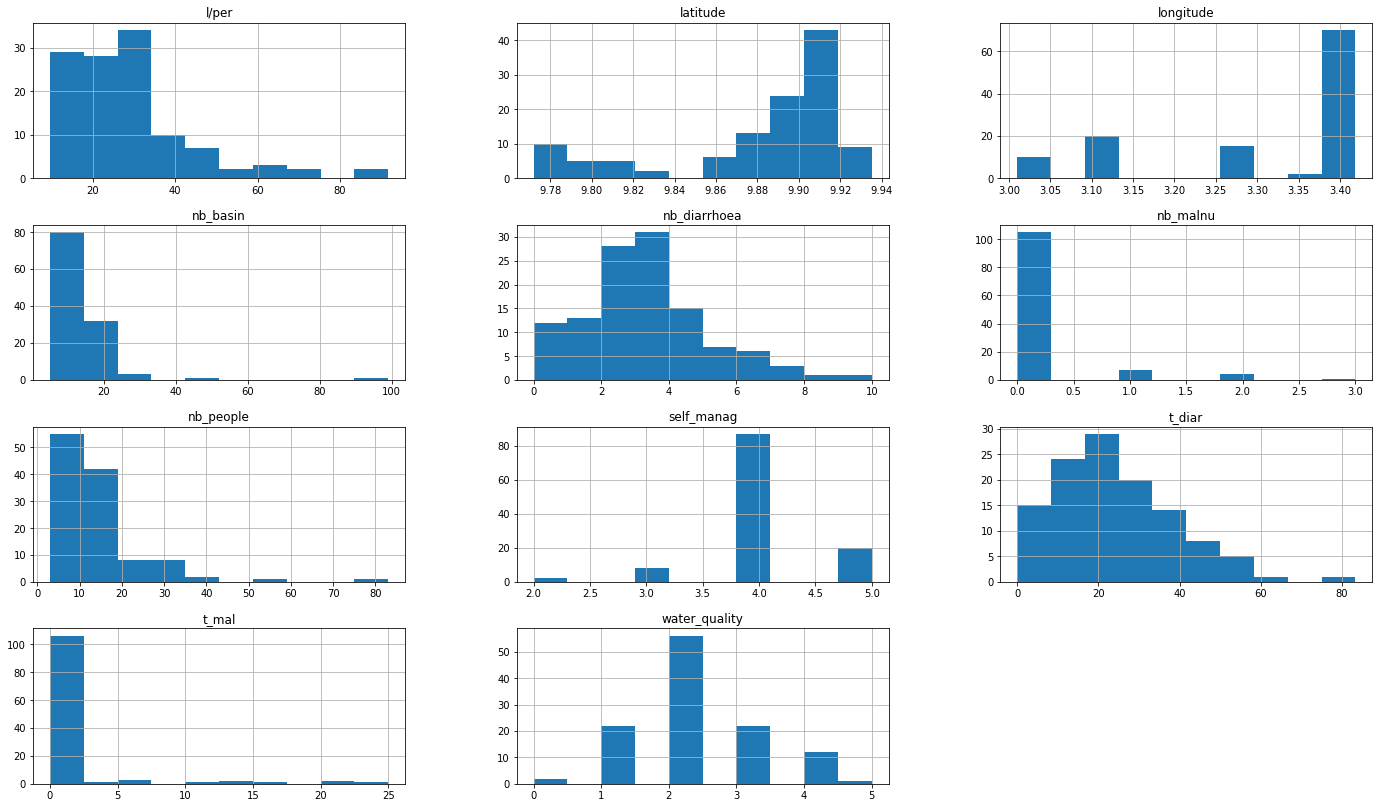

In [222]:
df_priority.hist()
plt.show()

In [233]:
df_priority.columns

Index(['latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'l/per', 't_diar', 't_mal', 'village'],
      dtype='object')

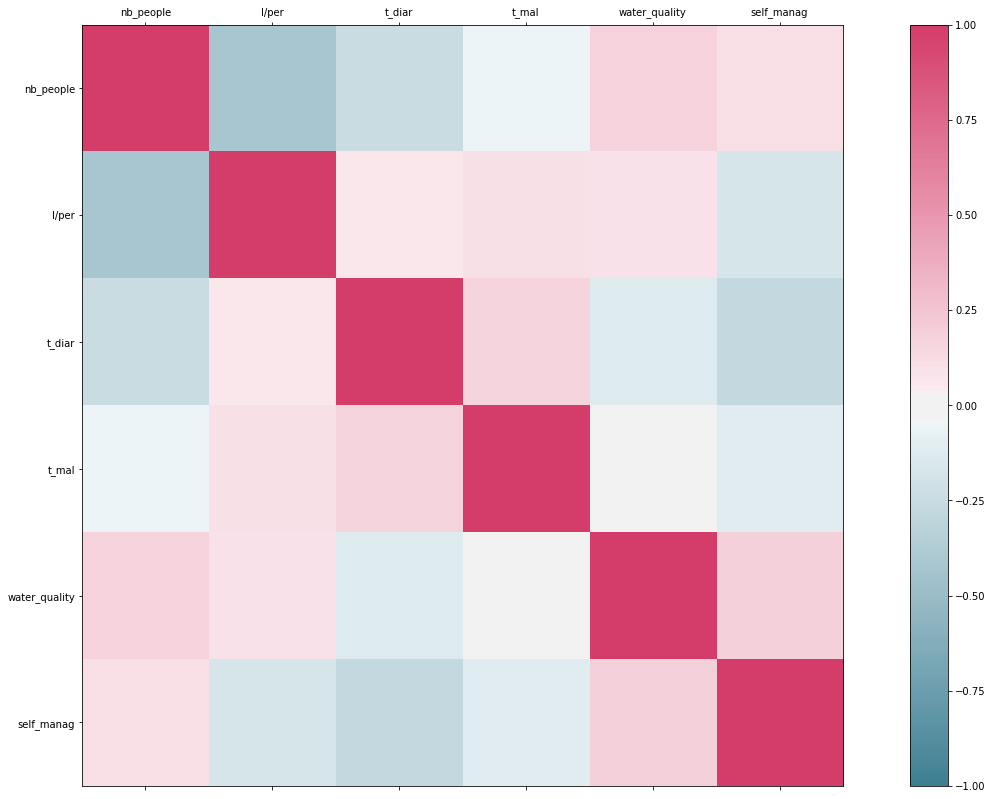

In [264]:
df_correlations = df_priority[['nb_people','l/per','t_diar',
                               't_mal','water_quality','self_manag']].copy()
names=df_correlations.columns
correlations = df_correlations.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, cmap=sns.diverging_palette(220, 0, as_cmap=True), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [259]:
correlations.style.background_gradient(cmap='coolwarm').set_precision(2)

,nb_people,l/per,t_diar,t_mal,water_quality,self_manag
nb_people,1,-0.42,-0.24,-0.046,0.17,0.1
l/per,-0.42,1,0.055,0.095,0.09,-0.17
t_diar,-0.24,0.055,1,0.17,-0.13,-0.27
t_mal,-0.046,0.095,0.17,1,0.017,-0.11
water_quality,0.17,0.09,-0.13,0.017,1,0.19
self_manag,0.1,-0.17,-0.27,-0.11,0.19,1


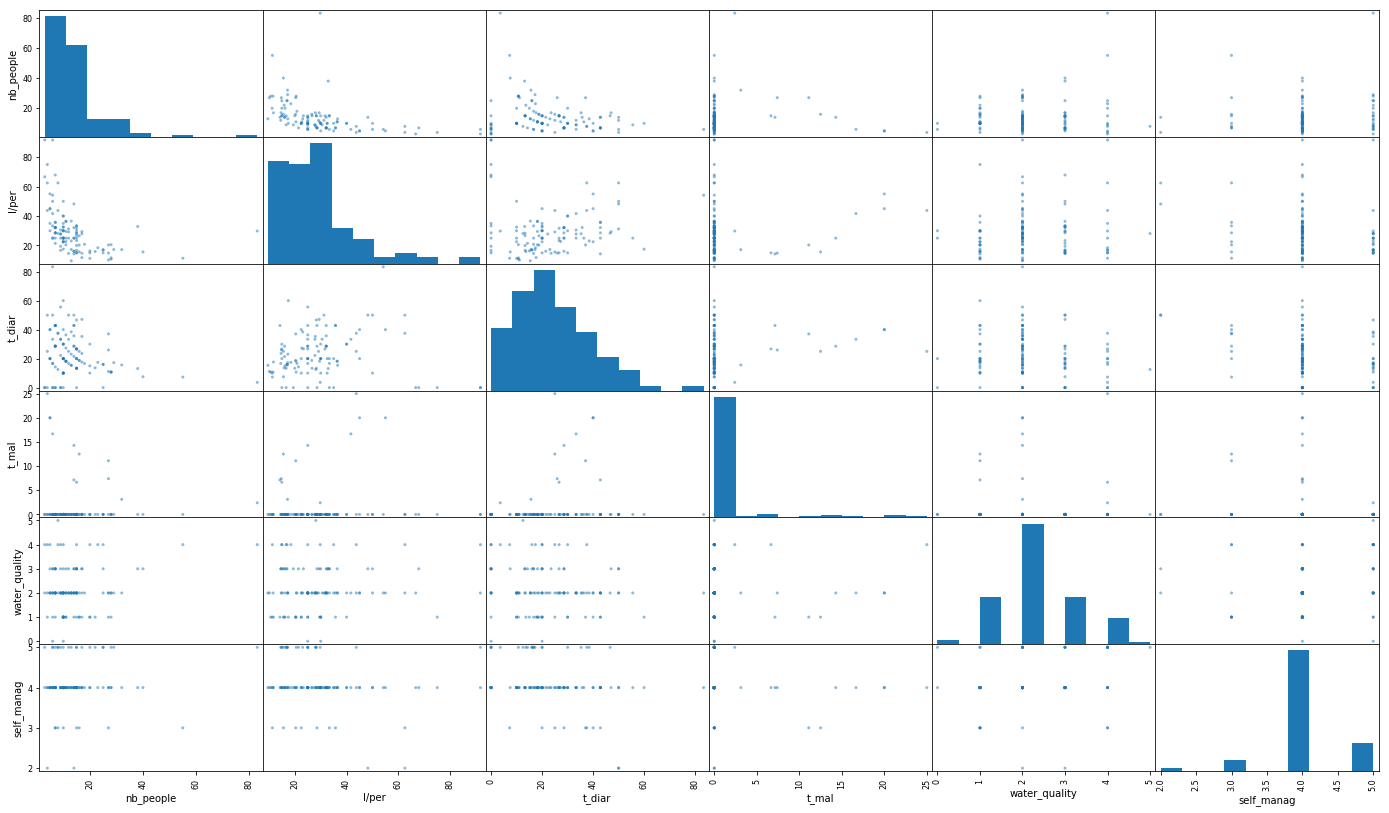

In [256]:
scatter_matrix(df_correlations)
plt.show()

In [271]:
df_priority.columns

Index(['latitude', 'longitude', 'creation_date', 'nb_basin', 'nb_people',
       'nb_diarrhoea', 'nb_malnu', 'water_storage', 'water_quality',
       'self_manag', 'role', 'l/per', 't_diar', 't_mal', 'village'],
      dtype='object')

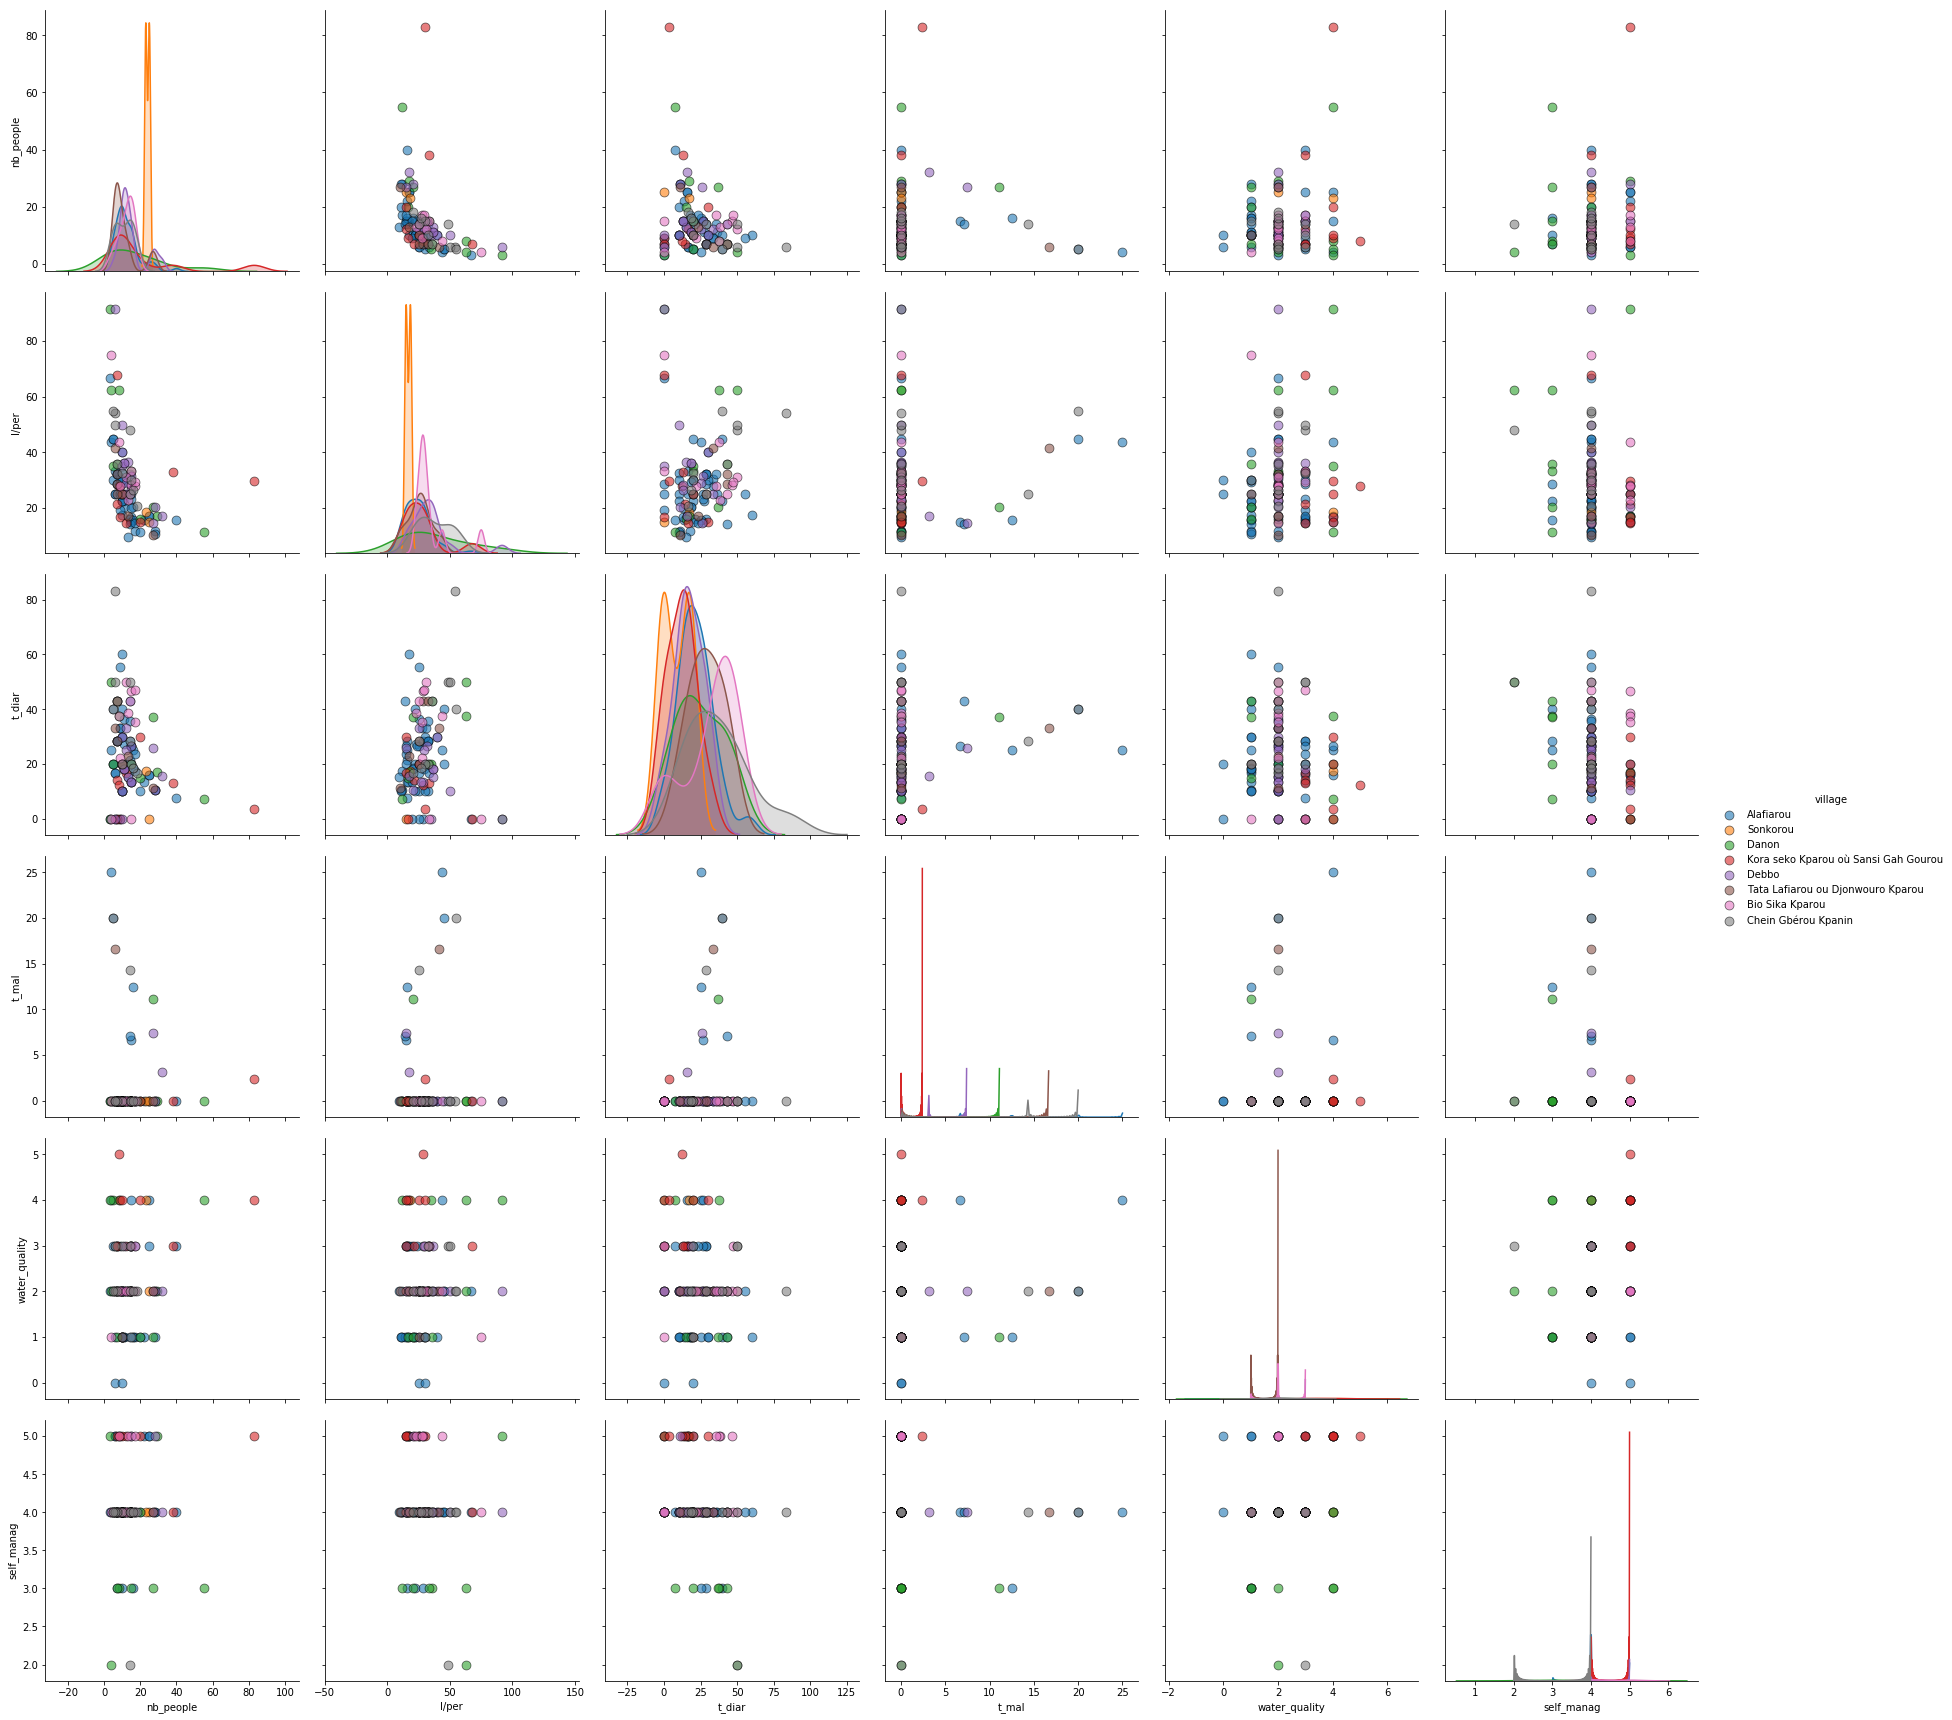

In [273]:
df_correlations = df_priority[['village','nb_people','l/per','t_diar',
                               't_mal','water_quality','self_manag']].copy()

sns.pairplot(df_correlations, hue = 'village', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)
plt.show()

## RELATION BETWEEN DIARREAH AND l/per

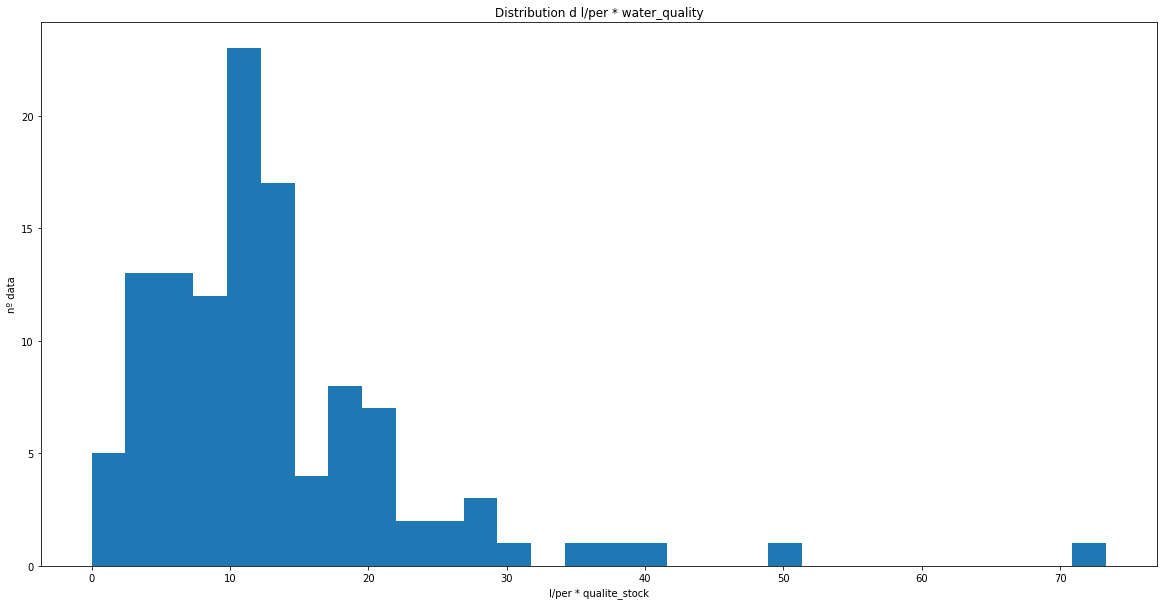

In [218]:
f, ax = plt.subplots(1, figsize=(20,10))

x=df_priority['l/per']*(df_priority['water_quality']/5)

ax.hist(x,bins=30)

ax.set_xlabel('l/per * qualite_stock')

ax.set_ylabel('nº data')

ax.set_title("Distribution d l/per * water_quality")

plt.show()

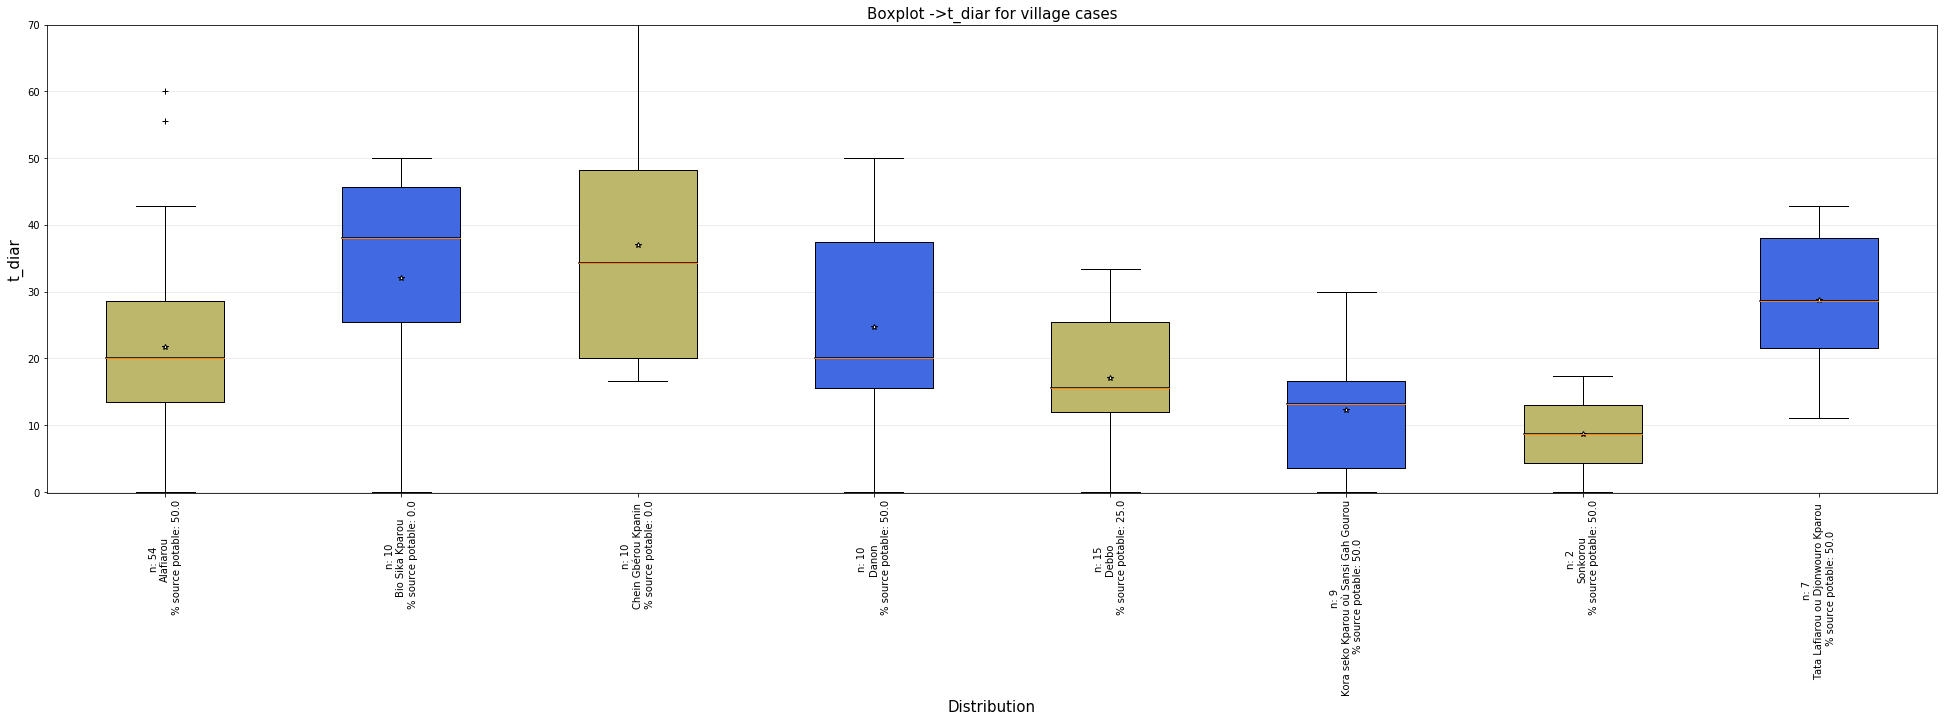

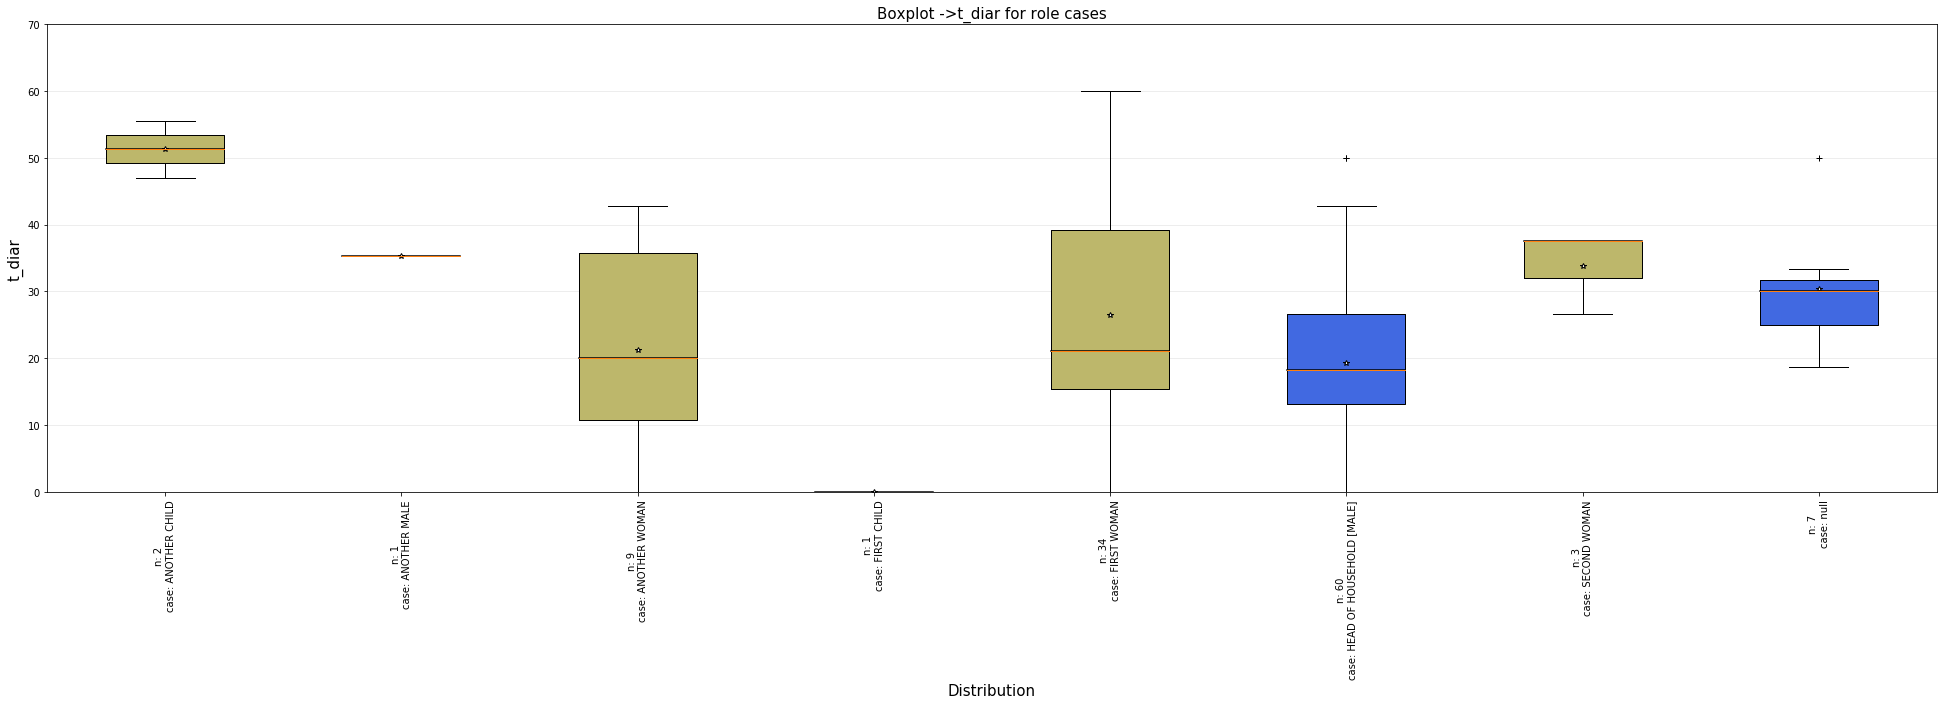

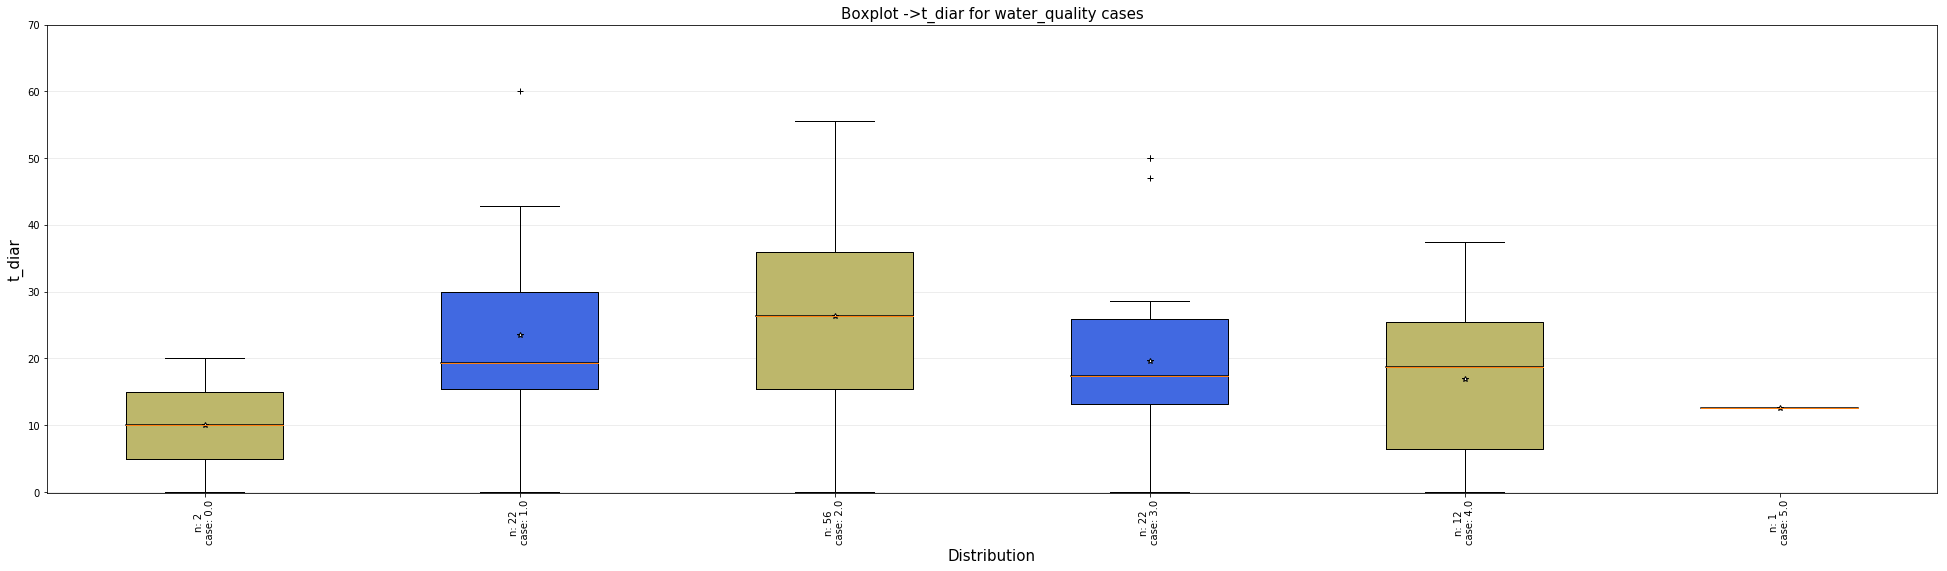

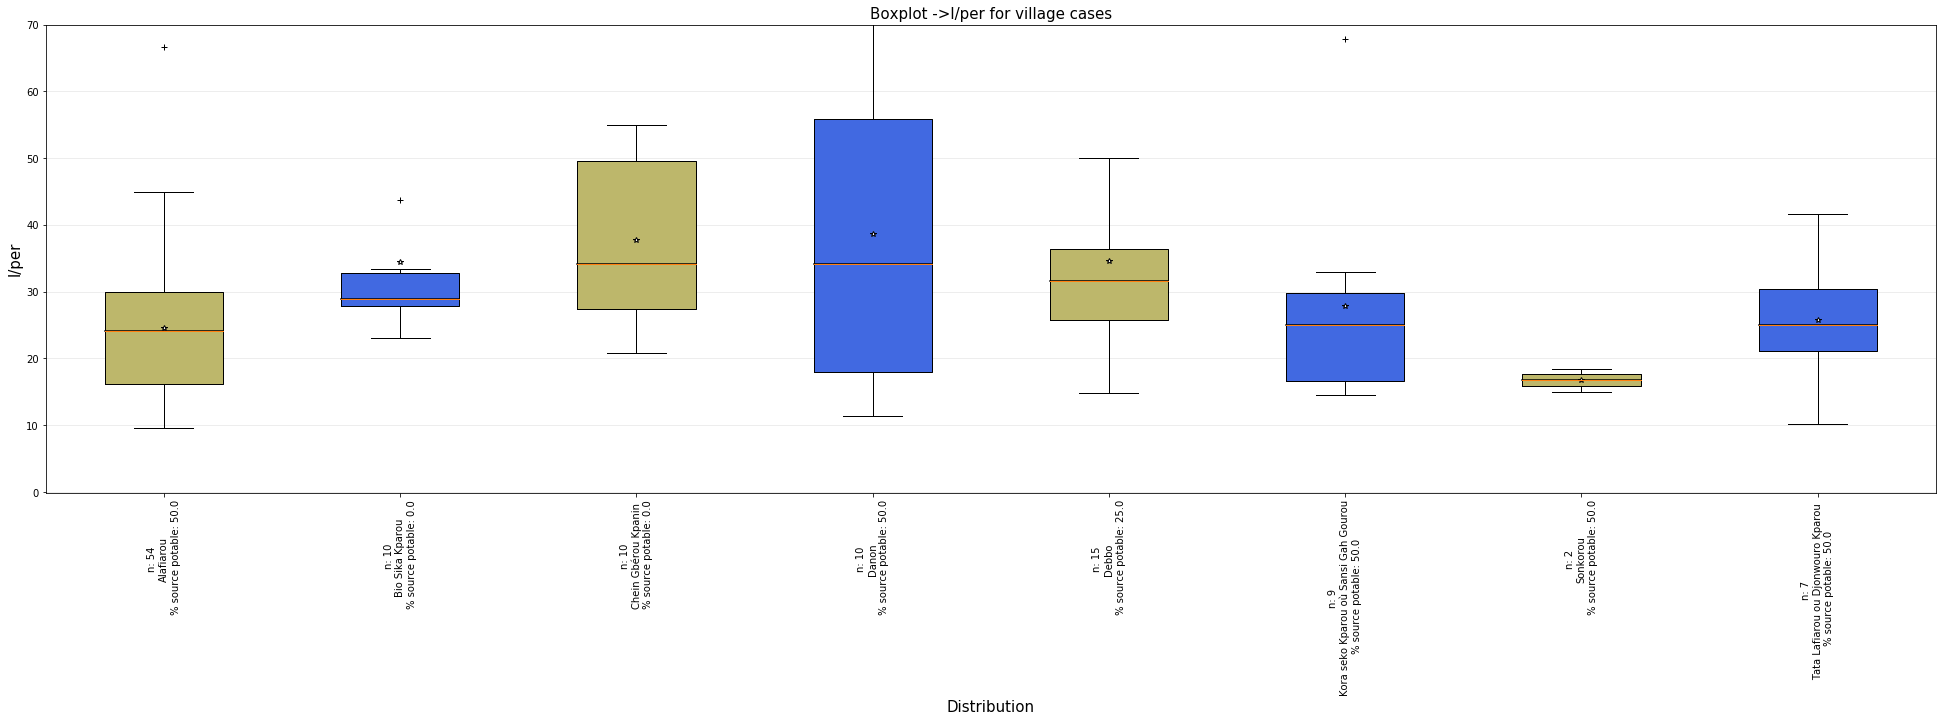

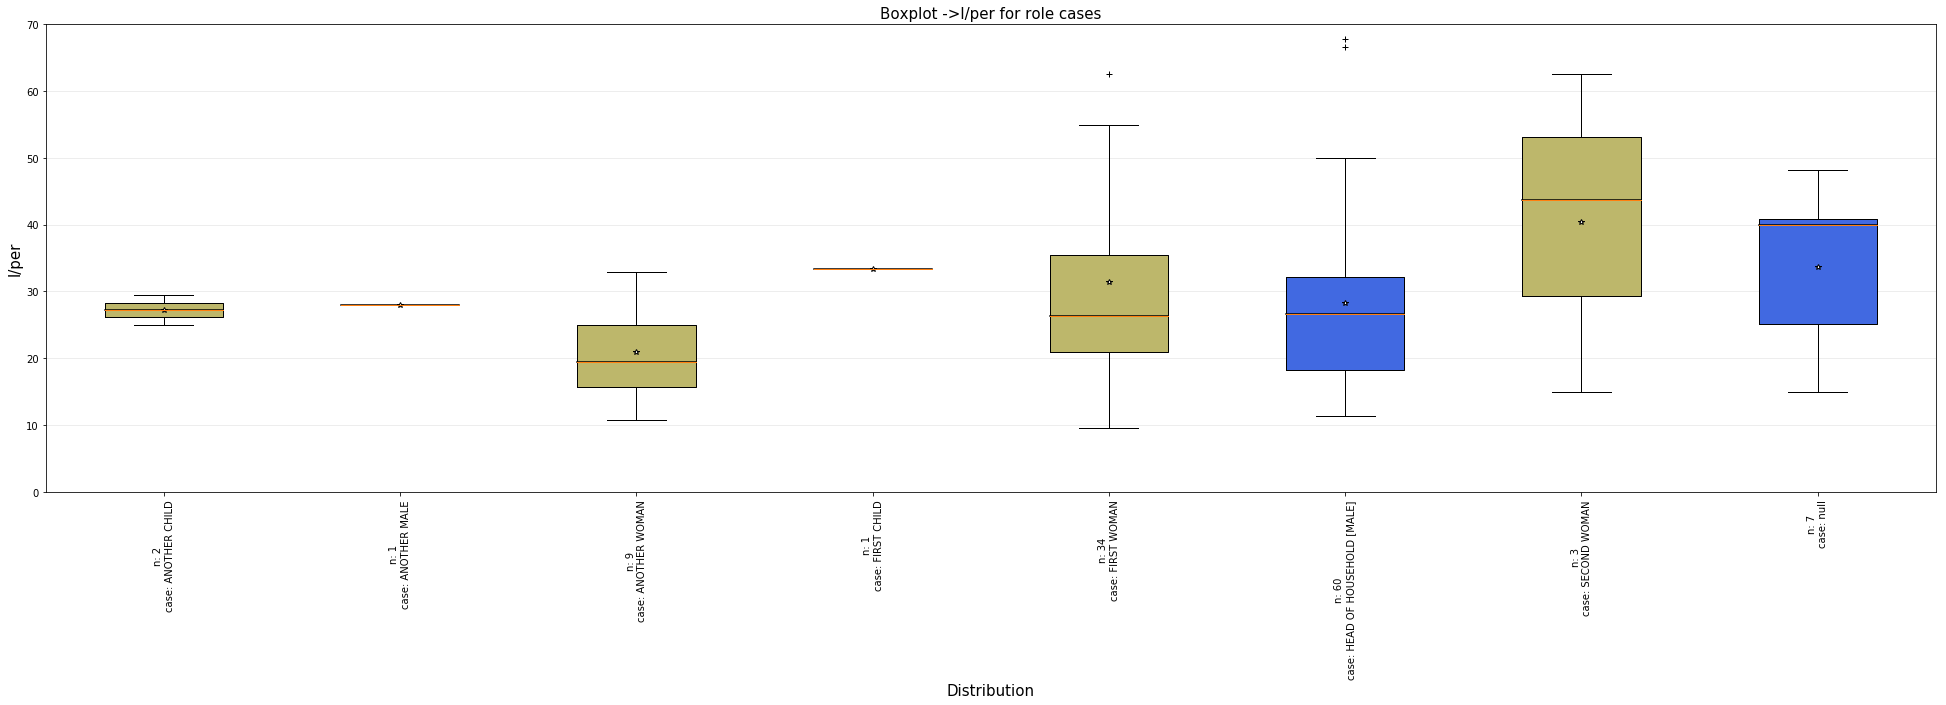

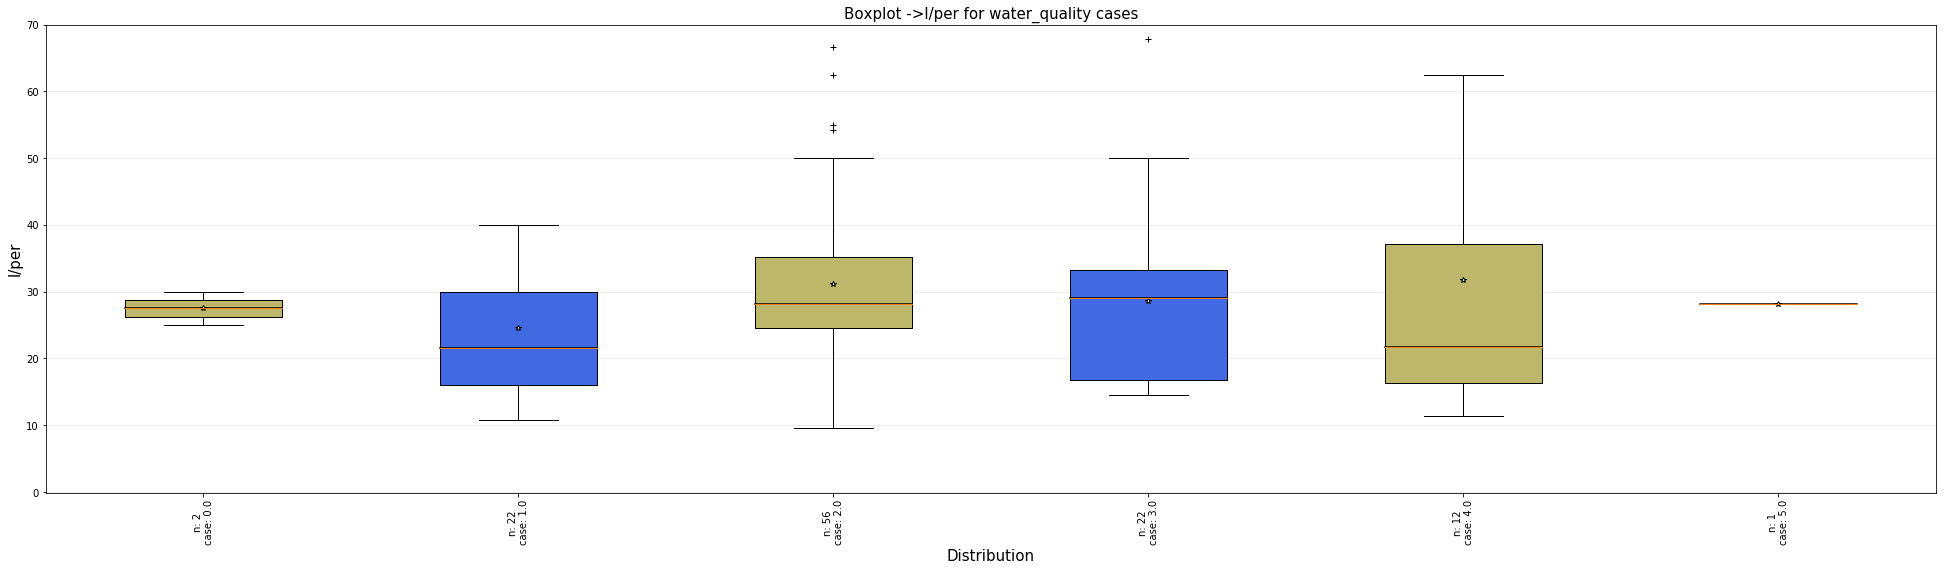

In [220]:
z=2

datas_to_filter=['village','role','water_quality']
values_to_show=['t_diar','l/per']
for value in values_to_show:
    for data_to_filter in datas_to_filter:
        cases=df_priority[data_to_filter].sort_values().dropna().unique()
        #wat_qual=df_priority['role'].sort_values().dropna().unique()
        data = [df_priority[df_priority[data_to_filter]==a][value] for a in cases]
        data_size= [len(a) for a in data]
        if data_to_filter == 'village':
            labels = ['n: '+str(data_siz)+'\n'+str(case)+'\n % source potable: '+str(df_village[df_village['village_name']==case]['%_s_potable'].values[0])
                      for data_siz,case in zip(data_size,cases)]
        else:
             labels = ['n: '+str(data_siz)+'\ncase: '+str(case)
                      for data_siz,case in zip(data_size,cases)]
        fig, ax1 = plt.subplots(figsize=(30, 10))
        #fig, ax1 = plt.subplots(figsize=(10, 6))

        fig.canvas.set_window_title('A Boxplot Example')
        fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

        bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
        plt.setp(bp['boxes'], color='black')
        plt.setp(bp['whiskers'], color='black')
        plt.setp(bp['fliers'], color='red', marker='+')

        # Add a horizontal grid to the plot, but make it very light in color
        # so we can use it for reading data values but not be distracting
        ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                       alpha=0.5)

        # Hide these grid behind plot objects
        ax1.set_axisbelow(True)
        ax1.set_title('Boxplot ->'+value+' for '+data_to_filter + ' cases',fontsize=15)
        ax1.set_xlabel('Distribution',fontsize=15)
        ax1.set_ylabel(value,fontsize=15)


        # Now fill the boxes with desired colors
        boxColors = ['darkkhaki', 'royalblue']
        numBoxes = len(cases)
        medians = list(range(numBoxes))
        for i in range(numBoxes):
            box = bp['boxes'][i]
            boxX = []
            boxY = []
            for j in range(5):
                boxX.append(box.get_xdata()[j])
                boxY.append(box.get_ydata()[j])
            boxCoords = np.column_stack([boxX, boxY])
            # Alternate between Dark Khaki and Royal Blue
            k = i % 2
            boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
            ax1.add_patch(boxPolygon)
            # Now draw the median lines back over what we just filled in
            med = bp['medians'][i]
            medianX = []
            medianY = []
            for j in range(2):
                medianX.append(med.get_xdata()[j])
                medianY.append(med.get_ydata()[j])
                ax1.plot(medianX, medianY, 'k')
                medians[i] = medianY[0]
            # Finally, overplot the sample averages, with horizontal alignment
            # in the center of each box
            ax1.plot([np.average(med.get_xdata())], [np.average(data[i])],
                     color='w', marker='*', markeredgecolor='k')

        # Set the axes ranges and axes labels
        ax1.set_xlim(0.5, numBoxes + 0.5)
        top = 70
        bottom = -70
        ax1.set_ylim(-0.1, top)
        ax1.set_xticklabels(labels,
                            rotation=90, fontsize=10)
        #ax1.set_xticklabels(list(csvData[z].index),
                            #rotation=45, fontsize=8)

        plt.show()

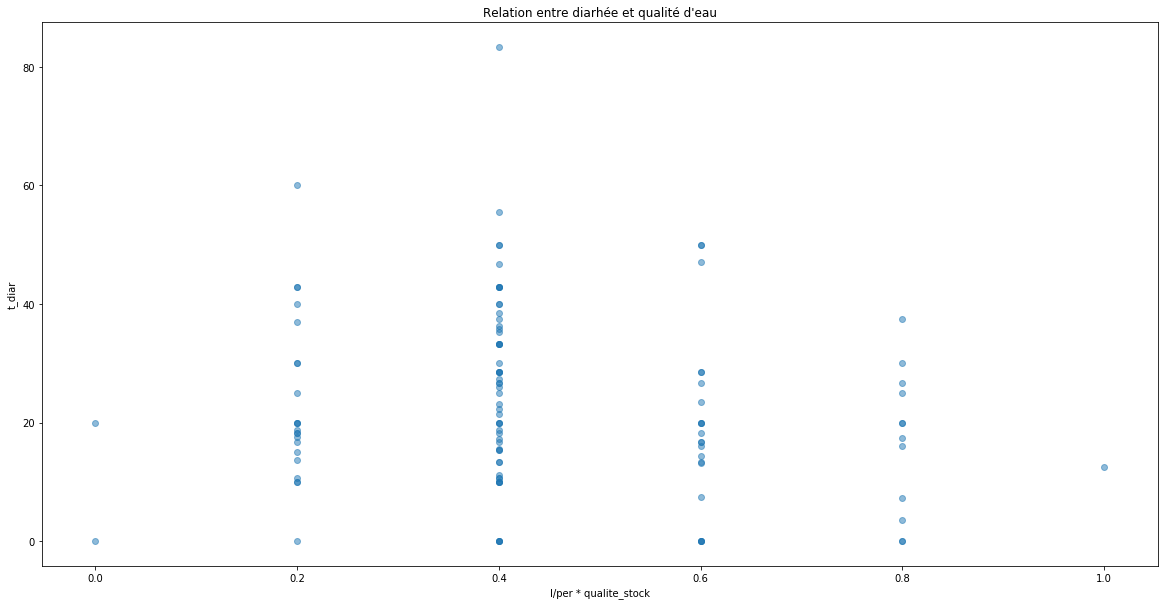

In [176]:
f, ax = plt.subplots(1, figsize=(20,10))

#x=df_priority['l/per']*(df_priority['water_quality']/5)

wat_qual=df_priority['water_quality'].sort_values().dropna().unique()
x=df_priority['water_quality']/5
y=df_priority['t_diar']

ax.scatter(x,y,alpha=0.5)

ax.set_xlabel('l/per * qualite_stock')

ax.set_ylabel('t_diar')

ax.set_title("Relation entre diarhée et qualité d'eau")

plt.show()

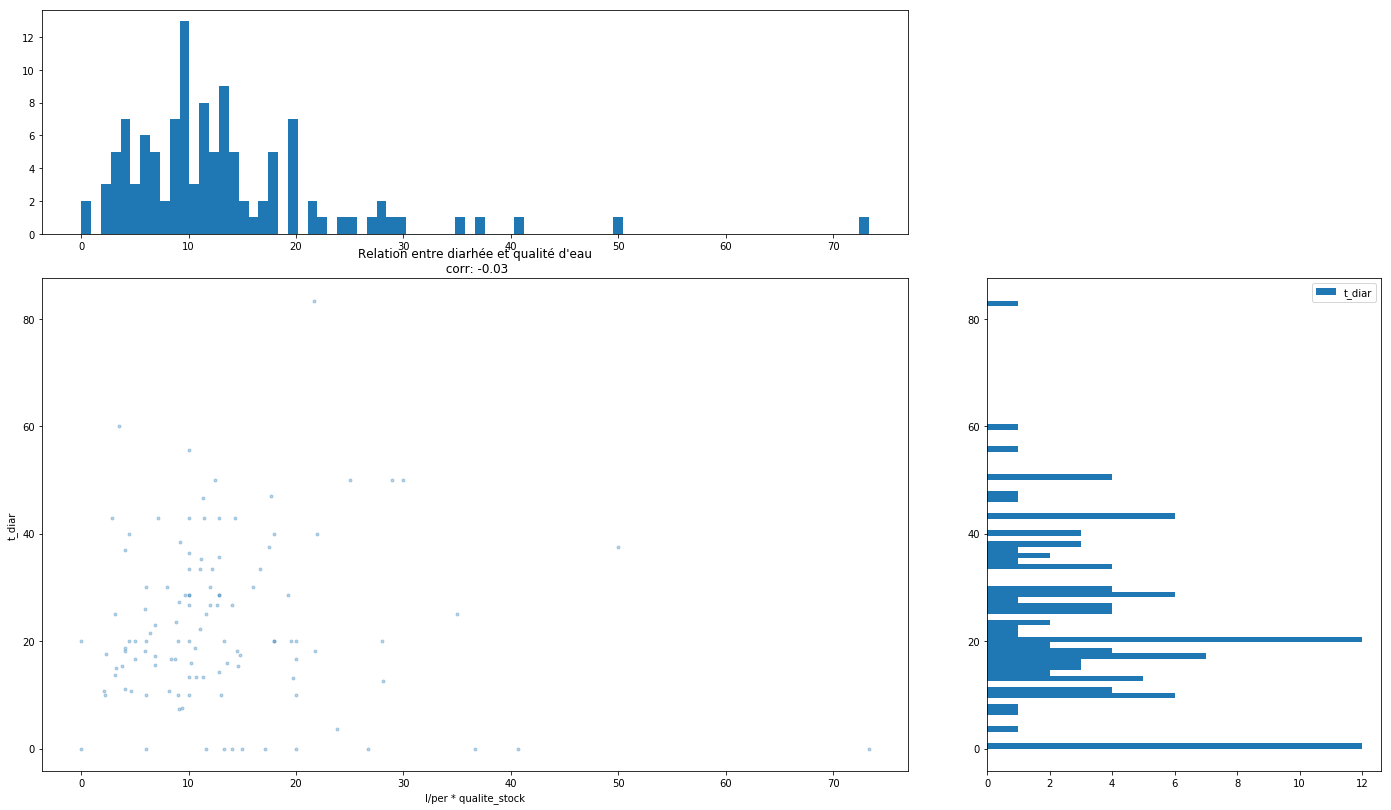

In [258]:
 # Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

df_plot=df_priority[(df_priority['l/per'].notnull()) &
         (df_priority['water_quality'].notnull()) &
         (df_priority['t_diar'].notnull())]

x=df_plot['l/per']*(df_plot['water_quality']/5)
#x=df_plot['water_quality']
y=df_plot['t_diar']

total_x, total_y = (np.array(x),np.array(y))

R2 = str(round(np.corrcoef(total_x, total_y)[1][0],2))

#scatter of variation in score and coverage relative variation and their histogram
scatter_axes = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
pyplot.title("Relation entre diarhée et qualité d'eau"+ "\n corr: " + R2)
pyplot.rcParams["figure.figsize"] = [24,14]
pyplot.xlabel("l/per * qualite_stock")
#pyplot.xlabel("qualite_stock")
pyplot.ylabel("t_diar")


x_hist_axes = plt.subplot2grid((3, 3), (0, 0), colspan=2,
                       sharex=scatter_axes)
y_hist_axes = plt.subplot2grid((3, 3), (1, 2), rowspan=2,
                       sharey=scatter_axes)

scatter_axes.plot(x, y, '.',alpha=0.3)
x_hist_axes.hist(x,bins=80)

y_hist_axes.hist(y, orientation='horizontal',bins=80)

pyplot.legend()
pyplot.show()

## CONTAR CASAS DESDE OPENSTREETMAPS

In [202]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = ("""
[out:json];
area['name'='"""+str('Debbo').upper()+
"""']->.a;
way[building](area.a);
(._;>;);
out body;
""")

overpass_query_2 = ("""
[out:json];
way['name'='"""+str('Debbo').upper()+
"""'];
way(around:1000)[building];
(._;>;);
out body;
""")

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
#response_2 = requests.get(overpass_url, 
#                        params={'data': overpass_query_2})
data = response.json()
#data = response_2.json()

In [203]:
houses = []
ways=[elem for elem in data['elements']  if elem['type']=='way']
nodes=[elem for elem in data['elements']  if elem['type']=='node']
for way in ways:
    houses_info={}
    houses_info['id']=way['id']
    nodes_lats=[]
    nodes_longs=[]
    houses_info['nodes']=way['nodes']
    for node in nodes:
        if node['id'] in houses_info['nodes']:
            nodes_lats.append(node['lat'])
            nodes_longs.append(node['lon'])
    houses_info['lat']=np.mean(np.array(nodes_lats))
    houses_info['lon']=np.mean(np.array(nodes_longs))
    houses.append(houses_info)

In [204]:
df_houses=pd.DataFrame(houses)

In [205]:
len(df_houses)

58

In [206]:
def distance(p_1,p_2):
    # approximate radius of earth in m
    R = 6373000

    lat1 = radians(p_1['lat'])
    lon1 = radians(p_1['lon'])
    lat2 = radians(p_2['lat'])
    lon2 = radians(p_2['lon'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [207]:
def has_been_survey(x):
    p_1={'lat':float(x['lat']),'lon':float(x['lon'])}
    points=df_priority.apply(lambda x: True
                             if distance(p_1,{'lat':x['latitude'],'lon':x['longitude']}) <40
                             else False
                                        ,axis=1)
    return points.any()

In [208]:
df_houses['surveyed']=df_houses.apply(lambda x: has_been_survey(x),axis=1)

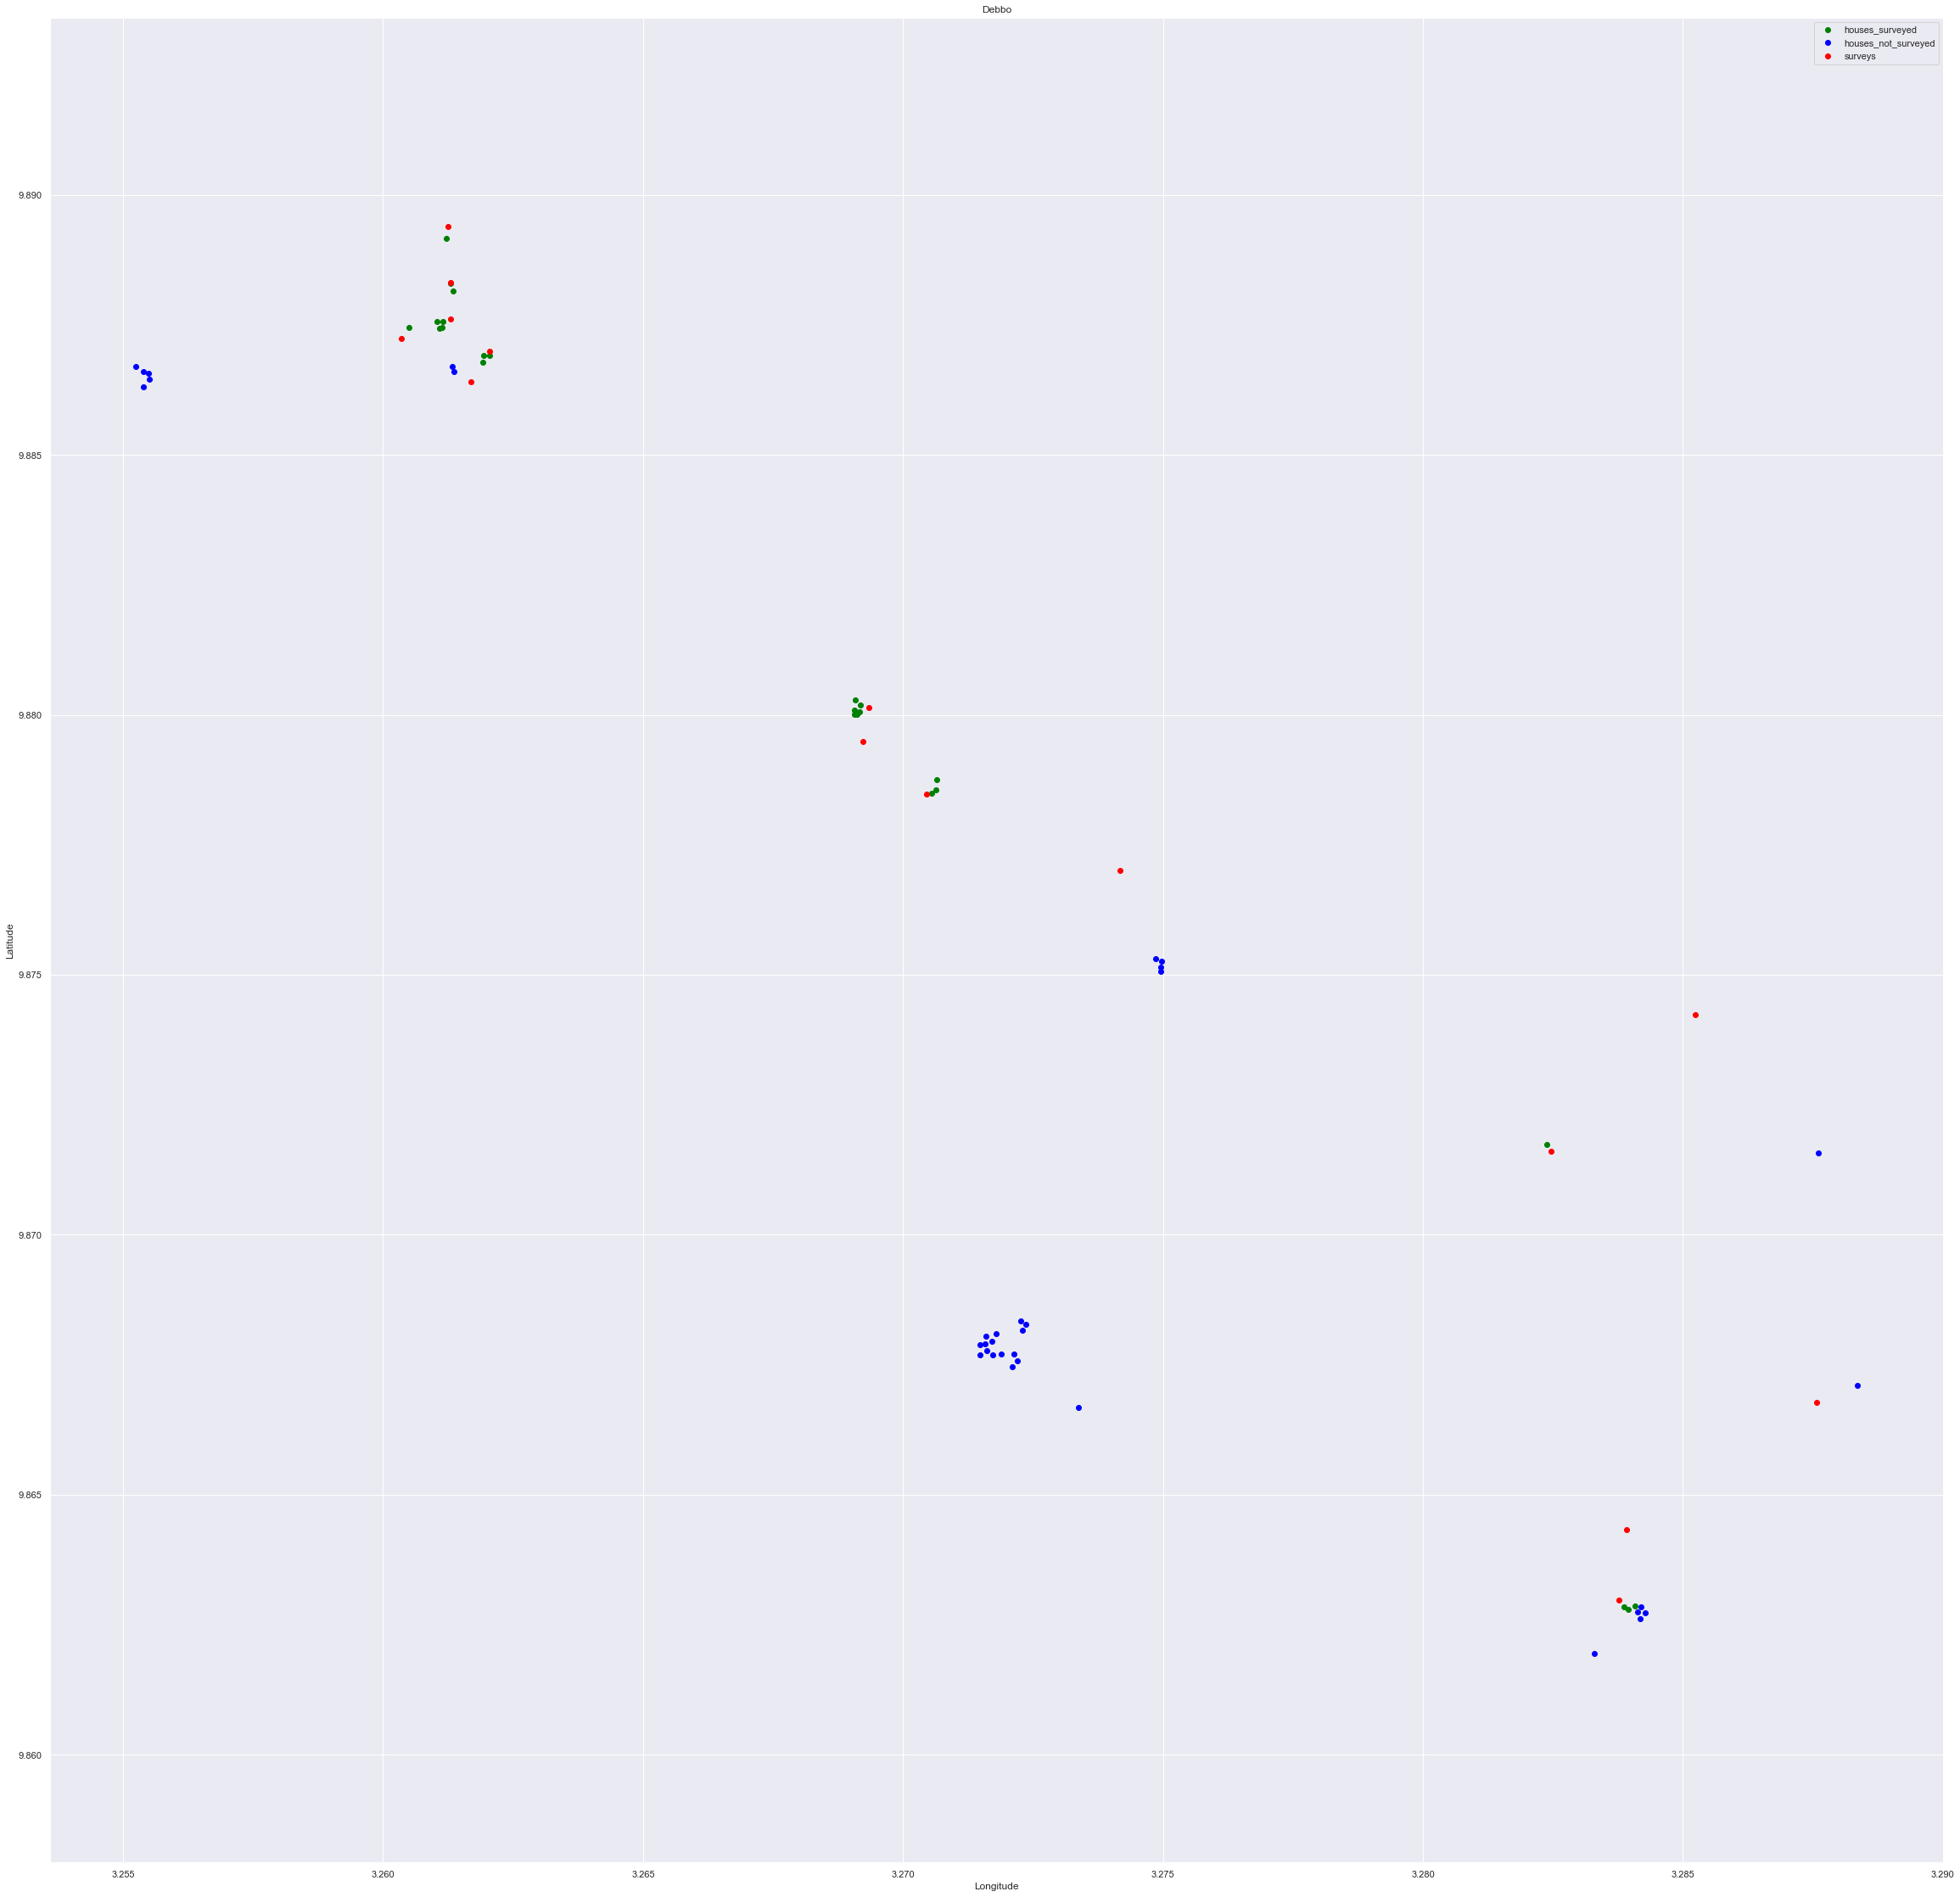

In [209]:
village='Debbo'
f,ax = plt.subplots(1,figsize=(40,40))
# Collect coords into list
coords = []

df_survey=df_houses[df_houses['surveyed']]
for a,b in zip(df_survey['lon'].to_list(),df_survey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='green',label='houses_surveyed')

coords = []
df_notsurvey=df_houses[~df_houses['surveyed']]
for a,b in zip(df_notsurvey['lon'].to_list(),df_notsurvey['lat'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='blue',label='houses_not_surveyed')

coords = []
df_debbo=df_priority[df_priority['village']==village]
for a,b in zip(df_debbo['longitude'].to_list(),df_debbo['latitude'].to_list()):
        coords.append((a, b))
# Convert coordinates into numpy array
X = np.array(coords)
ax.plot(X[:, 0], X[:, 1], 'o',color='red',label='surveys')


plt.title(village)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.legend()
plt.show()

# ESTIMACION DE LA POBLACION

In [210]:
def n_houses(x):
    p_1={'lat':x['latitude'],'lon':x['longitude']}
    points=df_houses.apply(lambda x: True
                             if distance(p_1,{'lat':x['lat'],'lon':x['lon']}) <40
                             else False
                                        ,axis=1)
    return points.sum()

In [211]:
df_priority['n_houses']=df_priority.apply(lambda x: n_houses(x),axis=1)

In [212]:
n_houses_surveyed=df_priority['n_houses'].sum()
n_houses_surveyed

24

In [213]:
n_people_belonging_to_houses=df_priority[df_priority['n_houses']!=0]['nb_people'].sum()
n_people_belonging_to_houses

125

In [214]:
n_total_houses=len(df_houses)
n_total_houses

58

In [215]:
#population estimate
n_people_belonging_to_houses*n_total_houses/n_houses_surveyed

302.0833333333333

In [216]:
#population in regards to survey
df_village[df_village['village_name']==village]['village_pop']

2    120
Name: village_pop, dtype: object

## DETERMINAR N MUESTRAL

<a href="https://towardsdatascience.com/how-to-use-python-to-figure-out-sample-sizes-for-your-study-871f0a76a19c">SOURCE</a>

In [116]:
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

In [117]:
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

In [138]:
p_diffs = [x*.01 for x in range(10,40)]

data = []
for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.05)
    record['Confidence Level'] = '95%'
    record['Initial probability'] = '20%'
    data.append(record)

for p_diff in p_diffs:
    record = {}
    record['Probability Difference'] = p_diff * 100
    record['Sample Size to Detect Difference'] = sample_required(p1=.5,
                                                                p_diff=p_diff,
                                                                alpha=.01)
    record['Confidence Level'] = '99%'
    record['Initial probability'] = '20%'
    data.append(record)

df = pd.DataFrame(data)

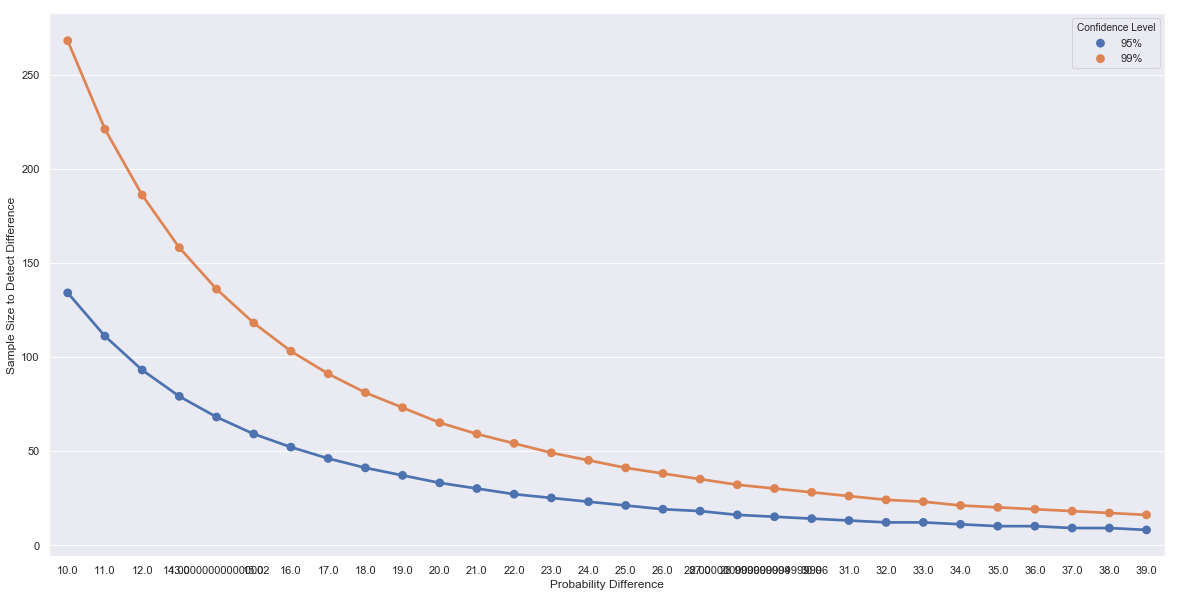

In [142]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(20, 10))

sns.set(style='darkgrid')

plot = sns.pointplot(x='Probability Difference',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)